In [16]:
# Project Progress Report — UCS Satellite Database
# Goal: Predict satellite Purpose from orbital and mass features.

# Target:`Purpose`  
# Predictors: `OrbitClass`, `GEOLongitude`, `Perigee`, `Apogee`, `Eccentricity`, `Inclination`, `Period`, `LaunchMass`

#Authors: Jess Hammond, Gary Kuepper, Keshab Neupane

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import title
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Read the Data

In [18]:

# UCS Satellite Database
# url: https://www.ucs.org/resources/satellite-database
url = "UCS-Satellite-Database-Officialname_5-1-2023.xlsx"
df_ucs = pd.read_excel(url, sheet_name="Sheet1")
print(df_ucs.info())

# Satcat Data
# url: https://www.celestrak.org/satcat/satcat-format.php

file = "satcat.csv"
df_satcat = pd.read_csv(file)
print(df_satcat.info())
df = pd.merge(df_ucs, df_satcat, left_on='NORAD Number', right_on='NORAD_CAT_ID')

# df.to_csv("merged_data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Current Official Name of Satellite  7560 non-null   object 
 1   Country/Org of UN Registry          7559 non-null   object 
 2   Country of Operator/Owner           7560 non-null   object 
 3   Operator/Owner                      7560 non-null   object 
 4   Users                               7560 non-null   object 
 5   Purpose                             7560 non-null   object 
 6   Detailed Purpose                    1254 non-null   object 
 7   Class of Orbit                      7560 non-null   object 
 8   Type of Orbit                       6909 non-null   object 
 9   Longitude of GEO (degrees)          7557 non-null   float64
 10  Perigee (km)                        7553 non-null   float64
 11  Apogee (km)                         7553 no

## Initial Exploration/Data Cleaning
 This cleans the table: we rename long column names to shorter ones, drop the junk "Unnamed:*" columns, merge all the Source* columns into one text field (SourcesAll), and convert LaunchDate to a real date so we can also make LaunchYear.

In [19]:
# Clean data
rename_map = {
    'Current Official Name of Satellite': 'SatelliteName',
    'Country/Org of UN Registry': 'UNRegistry',
    'Country of Operator/Owner': 'Country',
    'Operator/Owner': 'Operator',
    'Users': 'Users',
    'Purpose': 'Purpose',
    'Detailed Purpose': 'DetailedPurpose',
    'Class of Orbit': 'OrbitClass',
    'Type of Orbit': 'OrbitType',
    'Longitude of GEO (degrees)': 'GEOLongitude',
    'Perigee (km)': 'Perigee',
    'Apogee (km)': 'Apogee',
    'Eccentricity': 'Eccentricity',
    'Inclination (degrees)': 'Inclination',
    'Period (minutes)': 'Period',
    'Launch Mass (kg.)': 'LaunchMass',
    'Dry Mass (kg.)': 'DryMass',
    'Power (watts)': 'Power',
    'Date of Launch': 'LaunchDate',
    'Expected Lifetime (yrs.)': 'LifetimeYrs',
    'Contractor': 'Contractor',
    'Country of Contractor': 'ContractorCountry',
    'Launch Site': 'LaunchSite',
    'Launch Vehicle': 'LaunchVehicle',
    'COSPAR Number': 'COSPAR',
    'NORAD Number': 'NORAD',
    'Comments': 'Comments',
    # Satcat.csv columns
    'OBJECT_NAME': 'SatelliteName',
    'OBJECT_ID': 'ObjectID',
    'NORAD_CAT_ID': 'NORAD',
    'OBJECT_TYPE': 'ObjectType',
    'OPS_STATUS_CODE': 'OPSStatusCode',
    'OWNER': 'Owner',
    'LAUNCH_DATE': 'LaunchDate_sc',
    'LAUNCH_SITE': 'LaunchSite_sc',
    'DECAY_DATE': 'DecayDate',
    'PERIOD': 'Period_sc',
    'INCLINATION': 'Inclination_sc',
    'APOGEE': 'Apogee_sc',
    'PERIGEE': 'Perigee_sc',
    'RCS': 'RCS',
    'DATA_STATUS_CODE': 'DataStatusCode',
    'ORBIT_CENTER': 'OrbitCenter',
    'ORBIT_TYPE': 'OrbitType'
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
df['OrbitClass'] = df['OrbitClass'].astype(str).str.upper()
# drop all Unnamed: columns
unnamed_cols = [c for c in df.columns if c.startswith("Unnamed:")]
df = df.drop(columns=unnamed_cols)

# combine Source columns into one text field
source_cols = [c for c in df.columns if c.startswith("Source")]
if len(source_cols) > 0:
    df['SourcesAll'] = df[source_cols] \
        .astype(str) \
        .replace({'nan': np.nan}) \
        .apply(lambda row: "; ".join([v for v in row if pd.notna(v)]), axis=1)
    df = df.drop(columns=source_cols)

if 'LaunchDate' in df.columns:
    df['LaunchDate'] = pd.to_datetime(df['LaunchDate'], errors='coerce')
    df['LaunchYear'] = df['LaunchDate'].dt.year

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SatelliteName      7560 non-null   object        
 1   UNRegistry         7559 non-null   object        
 2   Country            7560 non-null   object        
 3   Operator           7560 non-null   object        
 4   Users              7560 non-null   object        
 5   Purpose            7560 non-null   object        
 6   DetailedPurpose    1254 non-null   object        
 7   OrbitClass         7560 non-null   object        
 8   OrbitType          6909 non-null   object        
 9   GEOLongitude       7557 non-null   float64       
 10  Perigee            7553 non-null   float64       
 11  Apogee             7553 non-null   float64       
 12  Eccentricity       7549 non-null   float64       
 13  Inclination        7556 non-null   float64       
 14  Period  

#### Cleaning User column

In [20]:

# Clean up users data as there are many duplicates
print(f"Old Users")
print(df['Users'].value_counts(dropna=False))
syn_map = {
    'Govt': 'Government',
    'Gov': 'Government',
    'Government': 'Government',
    'Military': 'Military',
    'Commercial': 'Commercial',
    'Civil': 'Civil',
}

# Define a canonical order so joined categories are consistent
order = ['Commercial', 'Government', 'Military', 'Civil']
order_rank = {k: i for i, k in enumerate(order)}


def normalize_users(val):
    if pd.isna(val):
        return pd.NA
    # Split, trim, and standardize case
    tokens = [t.strip() for t in str(val).split('/')]
    tokens = [t for t in tokens if t != '']  # drop empties

    # Title-case to normalize, then apply synonyms map
    tokens = [syn_map.get(t.title(), t.title()) for t in tokens]

    # Deduplicate while keeping only known categories (optional: keep unknowns too)
    uniq = sorted(set(tokens), key=lambda x: order_rank.get(x, 999))

    if len(uniq) == 0:
        return pd.NA
    if len(uniq) == 1:
        return uniq[0]
    return '/'.join(uniq)


# Apply normalization (create a new column or overwrite existing)
df['Users'] = df['Users'].apply(normalize_users)

# If you want to overwrite the original column:
# df['Users'] = df['Users'].apply(normalize_users)

# Inspect results
print("\n New Clean Users")
print(df['Users'].value_counts(dropna=False))

Old Users
Users
Commercial                        6080
Government                         558
Military                           457
Civil                              160
Government/Commercial               97
Military/Commercial                 82
Military/Government                 56
Government/Civil                    40
Military/Civil                       7
Government/Military                  4
Commercial/Civil                     4
Civil/Government                     4
Civil/Military                       3
Commercial/Military                  2
Civil/Commercial                     1
Government/Commercial/Military       1
Commercial/Government                1
Commercial                           1
Government                           1
Military                             1
Name: count, dtype: int64

 New Clean Users
Users
Commercial                        6081
Government                         559
Military                           458
Civil                              16

#### Change OpstatusCode to verbose string

In [21]:
# Example mapping (adjust if your codes or wording differ)
status_map = {
    '+': 'Op',
    '-': 'Nonop',
    'P': 'POp',
    'B': 'Bkp/Stb',
    'S': 'Spare',
    'X': 'ExtMis',
    'D': 'Decayed',
    '?': 'Unknown'
    # Add any other codes you have if needed
}
df['Status'] = df['OPSStatusCode'].map(status_map)

#### Clean up of Purpose Column

This part cleans the Purpose text (drops blanks, trims spaces, fixes casing), then groups many messy purpose labels into a few simple buckets: Communications, Navigation, Technology (incl. educational/platform), Science (Earth), Science (Space), and Science (Earth+Space). We apply the mapper to create PurposeSuperAudit, print the new bucket counts, and list anything that still fell into Other so we can fix it.

In [22]:
target_col = 'Purpose'

num_cols = [c for c in ['Perigee', 'Apogee', 'Eccentricity', 'Inclination', 'LaunchYear', 'GEOLongitude'] if c in df.columns]
cat_cols = [c for c in ['OrbitClass', 'Users',  'Operator', 'Owner', 'Status'] if
            c in df.columns]

# Drop rows missing Purpose
dfm = df.dropna(subset=[target_col]).copy()
# Remove leading/trailing spaces and double spaces
dfm[target_col] = (
    dfm[target_col]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

# Standardize capitalization
dfm[target_col] = dfm[target_col].str.title()

# Old buckets
num_of_old_buckets = dfm[target_col].value_counts()
print(f"\nOld Buckets: {len(num_of_old_buckets)}")


# print(dfm['DetailedPurpose'].value_counts().head(50))


# Combine purposes and remove redundant labels (Eg. Space Science & Space Observation)
def map_purpose(p):
    s = str(p).lower().strip()
    s = " ".join(s.split())

    # Buckets
    if any(k in s for k in ["surveillance"]):
        return "Surveillance"

    if any(k in s for k in ["navigation", "positioning"]):
        return "Navigation"

    if any(k in s for k in ["mission extension", "technology", "educational", "education", "platform"]):
        return "Tech Demo"

    if any(k in s for k in ["science", "space", "earth", "meteorolog"]):
        return "Science"

    if any(k in s for k in ["communications", "communication"]):
        return "Communications"

    return "Other"


dfm["PurposeSuperAudit"] = dfm["Purpose"].apply(map_purpose)

# New buckets
print("\nNew Buckets")
print(dfm["PurposeSuperAudit"].value_counts())




Old Buckets: 30

New Buckets
PurposeSuperAudit
Communications    5519
Science           1390
Tech Demo          455
Navigation         166
Surveillance        20
Other               10
Name: count, dtype: int64


#### Further clean up of Military and Military satellites used for surveillance

In [23]:
# Keywords to detect in DetailedPurpose that should override PurposeSuperAudit
print("\nOld Buckets")
print(dfm["PurposeSuperAudit"].value_counts())

override_surveil = [
    "intelligence", "surveillance", "military", "reconnaissance",
    "comint", "signals", "spectrum monitoring", "military intelligence"
]

# AIS is maritime navigation system
override_nav = ["ais", "automatic identification system", "identification "]

def derive_from_detailed(p):
    s = str(p).lower().strip()
    s = " ".join(s.split())

    if any(k in s for k in override_surveil):
        # You can choose the target bucket here; using "Surveillance" as example
        return "Surveillance"

    if any(k in s for k in override_nav):
        # You can choose the target bucket here; using "Surveillance" as example
        return "Navigation"

    return None


# Compute overrides from DetailedPurpose
override_fetched = dfm["DetailedPurpose"].apply(derive_from_detailed)

# Apply overrides to existing PurposeSuperAudit, keeping original when no override
dfm["PurposeSuperAudit"] = override_fetched.where(override_fetched.notna(), dfm["PurposeSuperAudit"])

# Ensure there is a default for any remaining unknowns
dfm["PurposeSuperAudit"] = dfm["PurposeSuperAudit"].fillna("Other")

print("\nNew Buckets")
print(dfm["PurposeSuperAudit"].value_counts())


Old Buckets
PurposeSuperAudit
Communications    5519
Science           1390
Tech Demo          455
Navigation         166
Surveillance        20
Other               10
Name: count, dtype: int64

New Buckets
PurposeSuperAudit
Communications    5503
Science           1093
Tech Demo          453
Navigation         345
Surveillance       156
Other               10
Name: count, dtype: int64


#### Operational Status of Satellites grouped by Purpose

In [24]:
# dfm.to_csv("merged_clean_data.csv", index=False)
table = dfm.groupby('PurposeSuperAudit')['Status'].value_counts(dropna=False).unstack(fill_value=0)
table['Total'] = table.sum(axis=1)
table = table.sort_values(by='Total', ascending=False)
with pd.option_context('display.max_columns', None):
    print(table)
print("\n", table)

Status             Bkp/Stb  Decayed  ExtMis  Nonop    Op  POp  Spare  NaN  \
PurposeSuperAudit                                                           
Communications           4     1039       0     97  4120  240      0    3   
Science                  4      432       9     40   595    4      0    9   
Tech Demo                0      225       0     18   204    0      0    6   
Navigation               9      138       0     18   171    5      4    0   
Surveillance             0       15       0      4   131    0      0    6   
Other                    0        1       0      0     9    0      0    0   

Status             Total  
PurposeSuperAudit         
Communications      5503  
Science             1093  
Tech Demo            453  
Navigation           345  
Surveillance         156  
Other                 10  

 Status             Bkp/Stb  Decayed  ExtMis  Nonop    Op  POp  Spare  NaN  \
PurposeSuperAudit                                                           
Communicati

## Exploration and Visualization

Hue column present? True
Class sizes used in plot:
PurposeSuperAudit
Communications    500
Science           500
Tech Demo         451
Navigation        345
Surveillance      156
Other              10
Name: count, dtype: int64


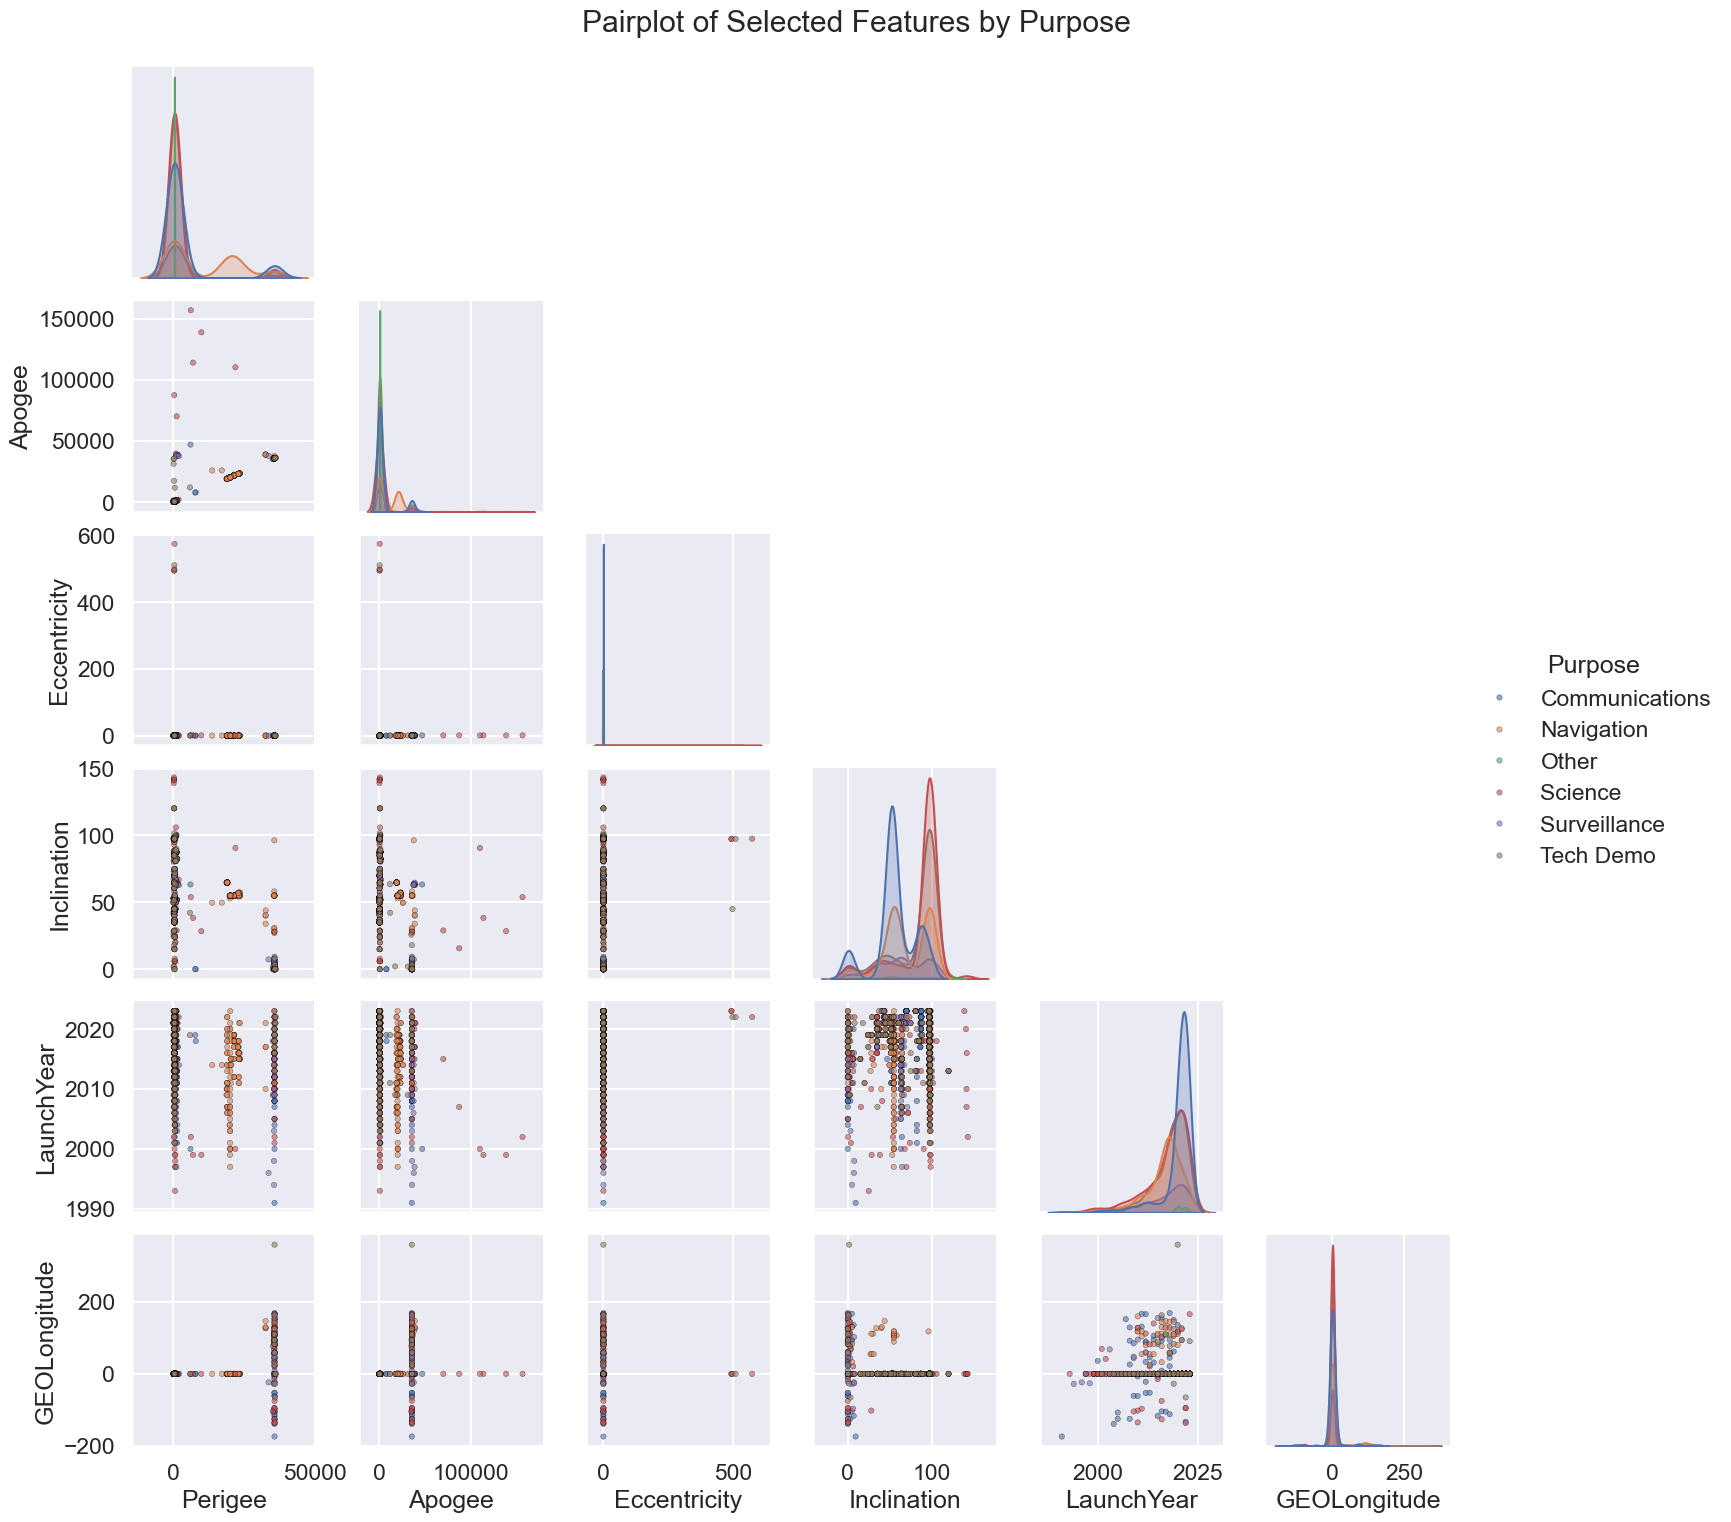

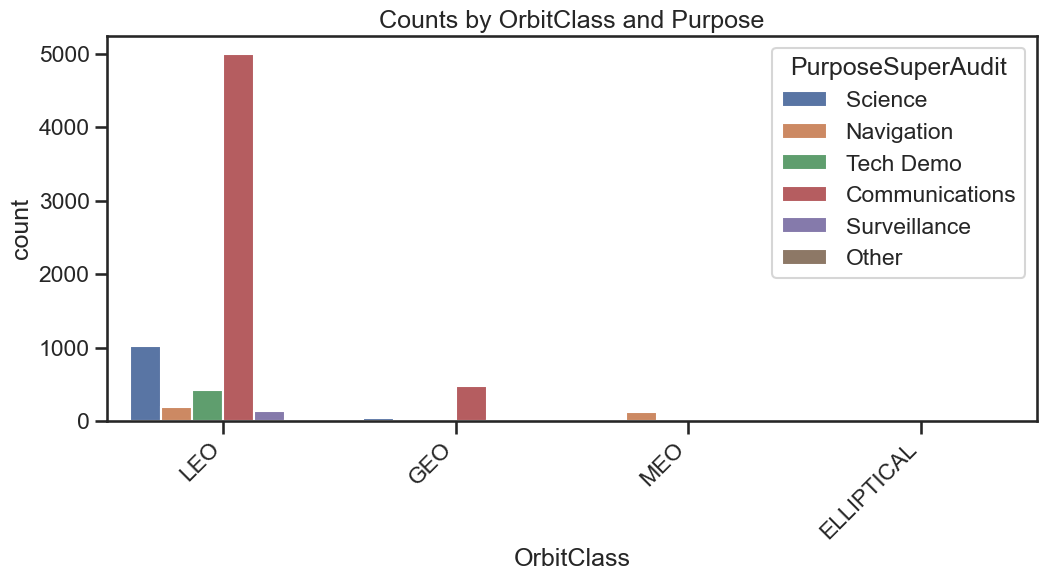

In [25]:


target_col = 'PurposeSuperAudit'  # or 'Purpose' if you prefer
max_points_per_class = 500

# Drop Unknown and ensure numerics present
df_plot = dfm.copy()
df_plot = df_plot[~df_plot[target_col].astype(str).str.lower().eq('unknown')]
df_plot = df_plot[num_cols + [target_col] + cat_cols].dropna(subset=num_cols)

# Downsample per class while preserving columns
df_plot_bal = (
    df_plot.groupby(target_col, group_keys=False)
    .sample(frac=1.0, random_state=42)  # shuffle within each class
    .groupby(target_col, group_keys=False)
    .head(max_points_per_class)  # cap per class
)

# Sanity checks
print('Hue column present?', target_col in df_plot_bal.columns)
print('Class sizes used in plot:')
print(df_plot_bal[target_col].value_counts())

# Make the pairplot
# sns.set(style='ticks', context='talk')
g = sns.pairplot(
    df_plot_bal,
    vars=num_cols,
    hue=target_col if target_col in df_plot_bal.columns else None,
    corner=True,
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'black'}
)
g.fig.suptitle('Pairplot of Selected Features by Purpose', y=1.02)
g._legend.set_title("Purpose")


plt.show()

sns.set(style='ticks', context='talk')
n = len(cat_cols)

plot_df = dfm.copy()
plot_df[target_col] = plot_df[target_col].astype(str).str.strip()
plot_df = plot_df[~plot_df[target_col].str.lower().eq('unknown')]

# Optional: order categories by total count
order_oc = plot_df['OrbitClass'].value_counts().index

plt.figure(figsize=(12, 5))
sns.countplot(data=plot_df, x='OrbitClass', hue=target_col, order=order_oc)
plt.title('Counts by OrbitClass and Purpose')
plt.xticks(rotation=45, ha='right')

plt.show()



## Training a Logistic Regression Model

We take the cleaned Purpose buckets, drop rows labeled “Unknown,” and split the data into train (80%) and test (20%). We fill missing numbers with the train median, turn OrbitClass into one-hot columns, and standardize the numeric features.

Then we train a Logistic Regression model, print the accuracy and the per-class scores, and show a confusion matrix to see which classes the model confuses.

In [26]:
target_col = "PurposeSuperAudit"

# Drop Unknown label
dfm_model = dfm[~dfm[target_col].isin(["Unknown"])].copy()

X = dfm_model[num_cols + cat_cols].copy()
y = dfm_model[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Impute numerics with median
for c in num_cols:
    med = X_train[c].median()
    X_train[c] = X_train[c].fillna(med)
    X_test[c] = X_test[c].fillna(med)

X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

# Trun orbitalclass into 0 or 1
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_cols])
Z_train_cat = ohe.transform(X_train[cat_cols])
Z_test_cat = ohe.transform(X_test[cat_cols])

# Scale numerics
scaler = StandardScaler().fit(X_train[num_cols])
Z_train_num = scaler.transform(X_train[num_cols])
Z_test_num = scaler.transform(X_test[num_cols])

# Combine features
Z_train = np.hstack([Z_train_num, Z_train_cat])
Z_test = np.hstack([Z_test_num, Z_test_cat])

lr = LogisticRegression(max_iter=600, solver='lbfgs',
                        class_weight=None)  # Tried class_weight='balance' but gave worse results
lr.fit(Z_train, y_train)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,600
,multi_class,'deprecated'


#### Model Performance

In [27]:
pred = lr.predict(Z_test)

print(f"\nAccuracy: {accuracy_score(y_test, pred):.3f}", )
print(classification_report(y_test, pred, zero_division=0))


Accuracy: 0.944
                precision    recall  f1-score   support

Communications       0.99      0.99      0.99      1100
    Navigation       0.98      0.88      0.93        69
         Other       0.00      0.00      0.00         2
       Science       0.81      0.88      0.85       219
  Surveillance       0.89      0.77      0.83        31
     Tech Demo       0.73      0.64      0.68        91

      accuracy                           0.94      1512
     macro avg       0.73      0.69      0.71      1512
  weighted avg       0.94      0.94      0.94      1512



['Communications', 'Navigation', 'Other', 'Science', 'Surveillance', 'Tech Demo']
[[1091    0    0    3    0    6]
 [   3   61    0    3    0    2]
 [   0    0    0    2    0    0]
 [   8    1    1  193    3   13]
 [   2    0    0    5   24    0]
 [   2    0    0   31    0   58]]


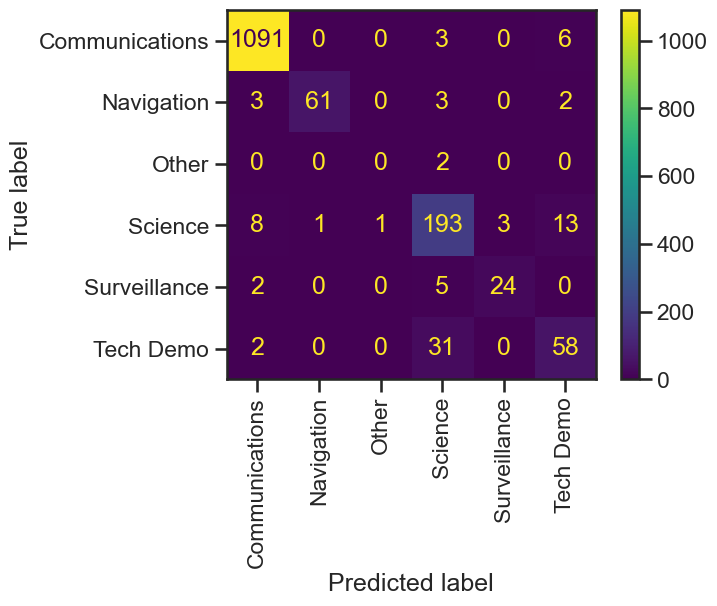

In [28]:
# confusion matrix
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, pred, labels=labels)
print(labels)
print(cm)

labels = sorted(y_test.unique())
ConfusionMatrixDisplay.from_predictions(y_test, pred, labels=labels, xticks_rotation=90)
plt.show()

In [29]:
# Bar chart shows how many satellites are in each Purpose bucket. Histograms show the spread of the numeric features (Perigee, Apogee, etc.).

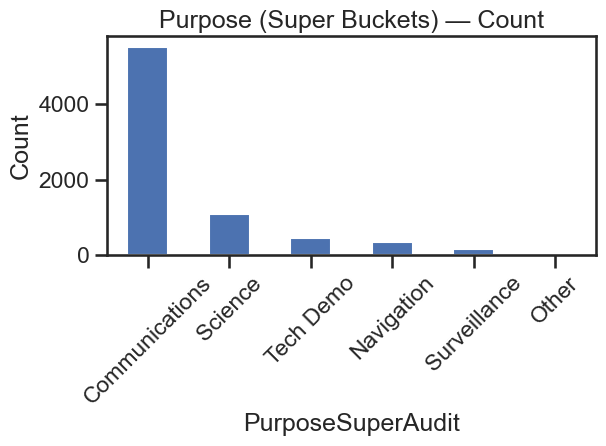

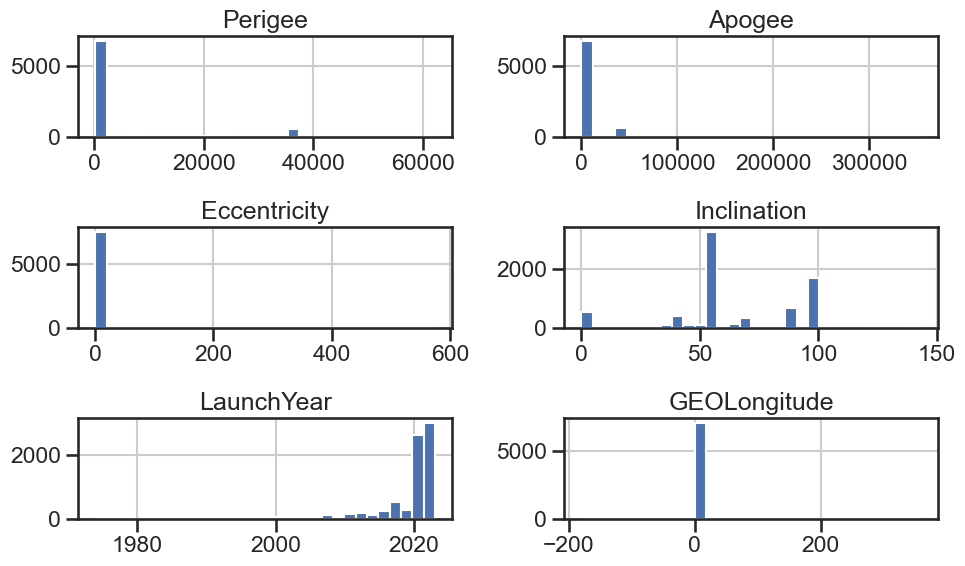

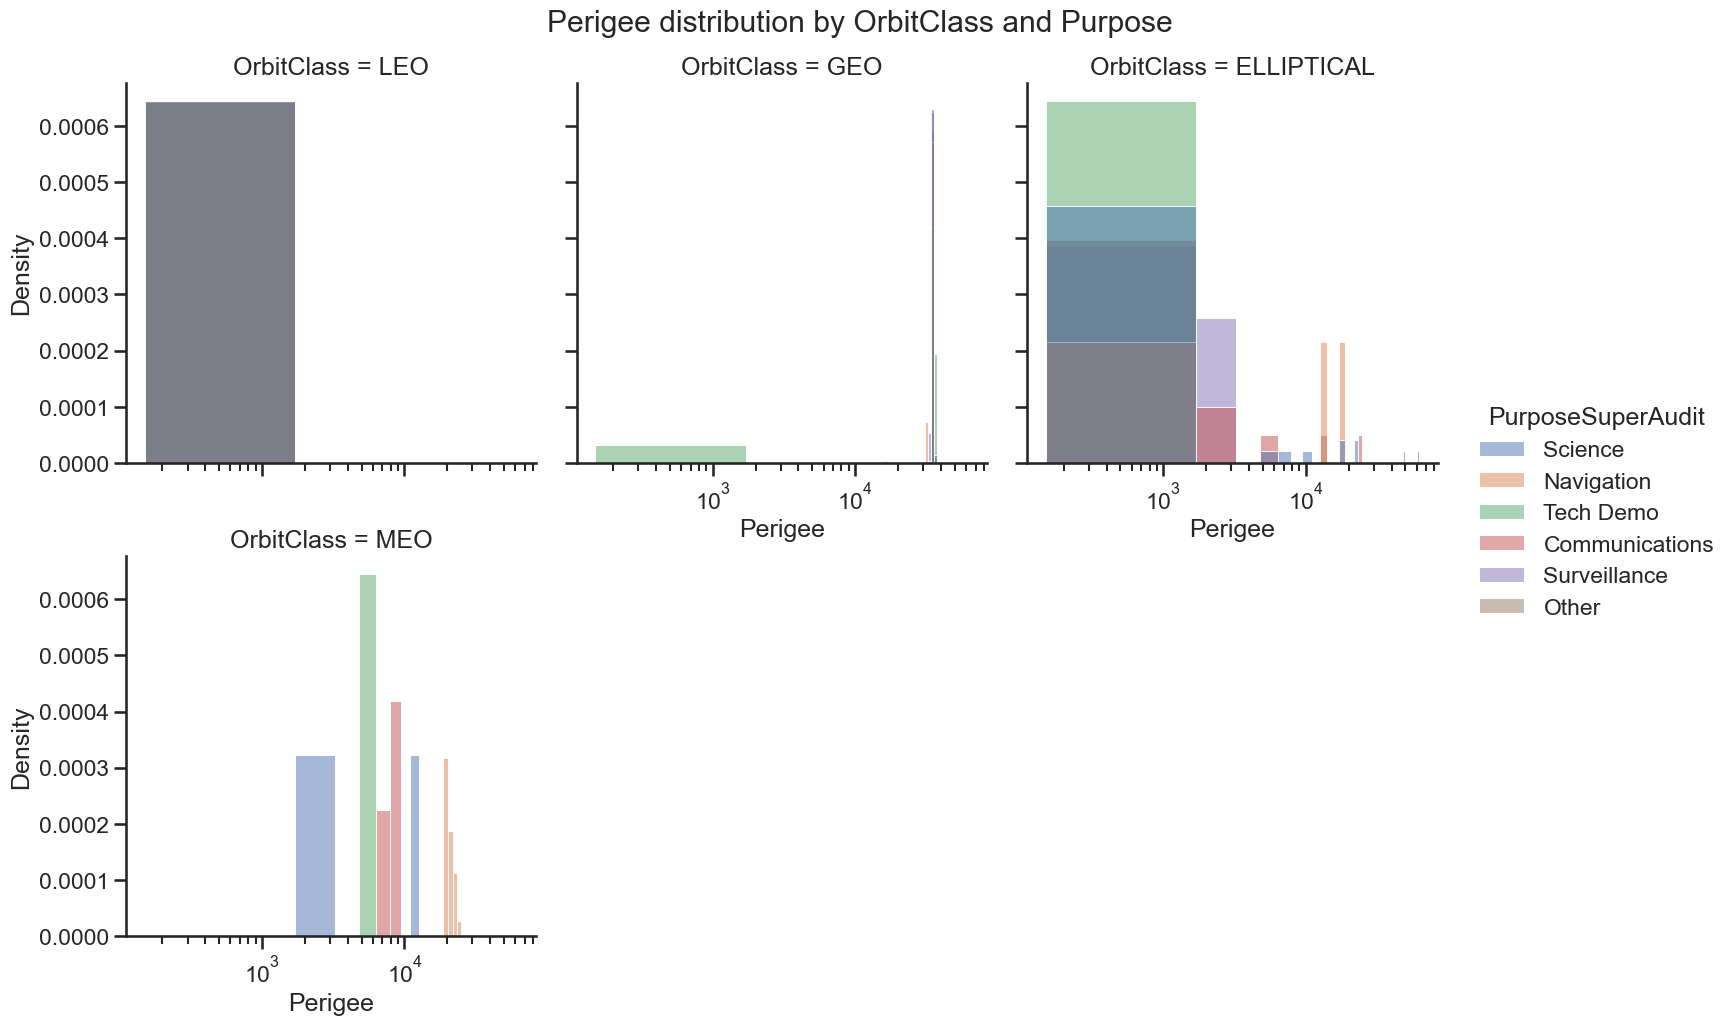

In [30]:
# Class counts bar chart
dfm["PurposeSuperAudit"].value_counts().plot(kind="bar", rot=45)
plt.title("Purpose (Super Buckets) — Count")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histograms for key numerics
dfm[num_cols].hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

if 'OrbitClass' in plot_df.columns:
    sns.displot(
        data=plot_df.dropna(subset=['Perigee']),
        x='Perigee', hue=target_col, col='OrbitClass',
        kind='hist', bins=40, multiple='layer', stat='density',
        common_bins=True, common_norm=False, col_wrap=3
    ).set(xscale='log')  # log helps for Perigee/Apogee
    plt.suptitle('Perigee distribution by OrbitClass and Purpose', y=1.02)
    plt.show()